# Domain Shift Fine-Tuning

## Missing Training split construction

Dense qrel matrix

In [5]:
import numpy as np
from itertools import combinations


def dense_matrix(num_of_queries: int, num_of_docs: int, k: int = 2) -> np.array:
    all_indexes = np.arange(num_of_docs)
    A = np.zeros((num_of_queries, num_of_docs), dtype=bool)
    for row, combo in zip(range(num_of_queries), combinations(all_indexes, k)):
        A[row, combo] = True

    return A

Dataset generation based on dense qrel pattern

In [9]:
import pandas as pd
import random

def generate_dataset(
    liked_items: list[str],
    names: list[str],
    qrel_matrix: np.ndarray,
    items_per_person: int,
    total_num_of_docs: int,
    seed: int = 42,
):
    num_of_queries, num_of_docs = qrel_matrix.shape
    random.seed(seed)

    query_items = random.sample(liked_items, num_of_queries)
    remaining_items = list(set(liked_items) - set(query_items))
    
    doc_ids = np.array(random.sample(names, num_of_docs))
    remaining_doc_ids = list(set(names) - set(doc_ids))
    
    docs = {}
    qrels_data = []
    
    # fill up the binary qrel structure with natural language
    for query_idx, (mask, item) in enumerate(zip(qrel_matrix, query_items)):
        selected_doc_ids = doc_ids[mask]
        for doc_id in selected_doc_ids:
            doc = docs.get(doc_id)
            if doc is None:
                docs[doc_id] = []
                doc = docs[doc_id]

            doc.append(item)
            qrels_data.append({
                "query-id": f"query_{query_idx}",
                "corpus-id": doc_id,
                "score": 1
            })
    
    # add remaining items to the docs
    for doc_id in docs:
        num_new_items_per_docs = items_per_person - len(docs[doc_id])
        new_items = random.sample(remaining_items, num_new_items_per_docs)
        docs[doc_id].extend(new_items)
        
    num_new_docs = total_num_of_docs - len(docs)
    if num_new_docs > 0:
        new_doc_ids = random.sample(remaining_doc_ids, num_new_docs)
        docs |= {
            doc_id: random.sample(remaining_items, items_per_person)
            for doc_id in new_doc_ids
        }
    
    # build and return the proper mteb format
    corpus = pd.DataFrame(
        [
            {
                "_id": doc_id,
                "title": "",
                "text": f"{doc_id} likes {', '.join(random.sample(docs[doc_id], len(docs[doc_id])))}."
            }
            for doc_id in docs
        ]
    )

    queries = pd.DataFrame(
        [
            {
                "_id": f"query_{query_idx}",
                "text": f"Who likes {item}?"
            }
            for query_idx, item in enumerate(query_items)
        ]
    )
    
    qrels = pd.DataFrame(qrels_data)
    
    return corpus, queries, qrels

In [10]:
import pandas as pd

# Use the custom ChatGPT generated attribute list
df = pd.read_csv("/kaggle/input/generated-attributes/train_set_attributes.csv")
liked_items = df["liked_item"].to_list()

# Use the same name distribution from the original dataset
df = pd.read_json("hf://datasets/orionweller/LIMIT/corpus.jsonl", lines=True)["_id"]
names = df.to_list()

In [11]:
A = dense_matrix(num_of_queries=1000, num_of_docs=46)

# Train set has similar structure as the test set
corpus, queries, qrels = generate_dataset(
    liked_items=liked_items,
    names=names,
    qrel_matrix=A,
    items_per_person=46,
    total_num_of_docs=50000,
    
)

# Generate dataset in JSONL MTEB format
corpus.to_json("corpus.jsonl", orient="records", lines=True)
queries.to_json("queries.jsonl", orient="records", lines=True)
qrels.to_json("qrels.jsonl", orient="records", lines=True)

In [12]:
len(corpus), len(queries), len(qrels)

(50000, 1000, 2000)

## Finetuning on test and train splits

Load test or train split

Load test set

In [1]:
from datasets import load_dataset, Dataset

dataset_name = "orionweller/LIMIT"
qrels = load_dataset(dataset_name, "default", split="test")
qrels = qrels.filter(lambda x: x["score"] > 0)
qrels = qrels.to_pandas()

corpus = load_dataset(dataset_name, "corpus", split="all").to_pandas()
queries = load_dataset(dataset_name, "queries", split="all").to_pandas()

# restructure dataset for contrastive learning
test_set = {
    "anchor": queries.set_index("_id").loc[qrels["query-id"]].reset_index()["text"].to_list(),
    "positive": corpus.set_index("_id").loc[qrels["corpus-id"]].reset_index()["text"].to_list()
}

train_dataset = Dataset.from_dict(test_set)

README.md: 0.00B [00:00, ?B/s]

qrels.jsonl: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

corpus.jsonl:   0%|          | 0.00/32.5M [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/50000 [00:00<?, ? examples/s]

queries.jsonl: 0.00B [00:00, ?B/s]

Generating queries split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Load train set

In [1]:
import pandas as pd
from datasets import Dataset

corpus = pd.read_json("/kaggle/input/limit-train-dataset/corpus.jsonl", lines=True)
queries = pd.read_json("/kaggle/input/limit-train-dataset/queries.jsonl", lines=True)
qrels = pd.read_json("/kaggle/input/limit-train-dataset/qrels.jsonl", lines=True)
train_set = {
    "anchor": queries.set_index("_id").loc[qrels["query-id"]].reset_index()["text"].to_list(),
    "positive": corpus.set_index("_id").loc[qrels["corpus-id"]].reset_index()["text"].to_list()
}

train_dataset = Dataset.from_dict(train_set)

In [2]:
len(qrels), len(queries), len(corpus)

(2000, 1000, 50000)

Load model

In [3]:
!nvidia-smi

Sun Feb  1 22:57:51 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# turn off the second GPU, compatibility issues...
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda"

In [5]:
from transformers import TrainerCallback
from tqdm.notebook import tqdm
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

class LivePlotTqdmCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.plot_display = None  # To hold the plot output

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        # Track loss
        if "loss" in logs:
            self.losses.append(logs["loss"])
            # Update plot without clearing tqdm
            plt.figure(figsize=(6,4))
            plt.plot(self.losses, label="train loss")
            plt.xlabel("Logging steps")
            plt.ylabel("Loss")
            plt.title("Training Loss")
            plt.legend()
            
            if self.plot_display is None:
                self.plot_display = display(plt.gcf(), display_id=True)
            else:
                self.plot_display.update(plt.gcf())
                
            plt.close()

In [6]:
from sentence_transformers import SentenceTransformer, models
import torch

def create_model(
    target_dimension: int,
    base_model_name: str = "lightonai/modernbert-embed-large", 
    device=device
) -> SentenceTransformer:
    transformer = models.Transformer(base_model_name)

    pooling = models.Pooling(
        transformer.get_word_embedding_dimension(),
        pooling_mode="mean"
    )
    
    projection = models.Dense(
        in_features=pooling.get_sentence_embedding_dimension(),
        out_features=target_dimension,
        bias=False,
        activation_function=torch.nn.Identity()
    )
    
    normalize = models.Normalize()
    
    model = SentenceTransformer(
        modules=[transformer, pooling, projection, normalize],
        device=device
    )
    return model

2026-02-01 22:58:01.999440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769986682.219818      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769986682.284004      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769986682.813626      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769986682.813663      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769986682.813666      55 computation_placer.cc:177] computation placer alr

Train on the selected split

In [7]:
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.losses import MultipleNegativesRankingLoss, CachedMultipleNegativesRankingLoss
from datasets import Dataset

def train(
    model: SentenceTransformer,
    batch_size: int,
    mini_batch_size: int,
    num_epochs: int,
    train_dataset: Dataset
):    
    # Cached InfoNCE loss sampler to increase the in batch negative ratio
    loss = CachedMultipleNegativesRankingLoss(
        model,
        mini_batch_size=mini_batch_size,   # what fits in GPU
    )
    
    args = SentenceTransformerTrainingArguments(    
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        learning_rate=5e-5,
        logging_steps=1,
        save_strategy="no",        
        batch_sampler=BatchSamplers.NO_DUPLICATES,
        report_to="none", # Disable external logging
    )
    
    trainer = SentenceTransformerTrainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        loss=loss,
    )
    
    trainer.add_callback(LivePlotTqdmCallback())
    trainer.train()

In [8]:
# training args
dimensions = [32, 64, 128, 256, 384, 512, 768, 1024]
splits = ["test", "train"]

target_dimension = dimensions[-4]
split = splits[1]

mini_batch_size = 8
batch_size = len(train_dataset)
num_epochs = 7

In [9]:
# Delete previous persisted models
!rm -rf /kaggle/working/*

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]


Starting to train model modernbert-embed-large-train-fine-tuned-limit-small-dim384...


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

W0201 22:58:46.212000 55 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Step,Training Loss
1,3.707100
2,3.586200
3,3.422200
4,3.200600
5,3.006800
6,3.154800
7,2.945800


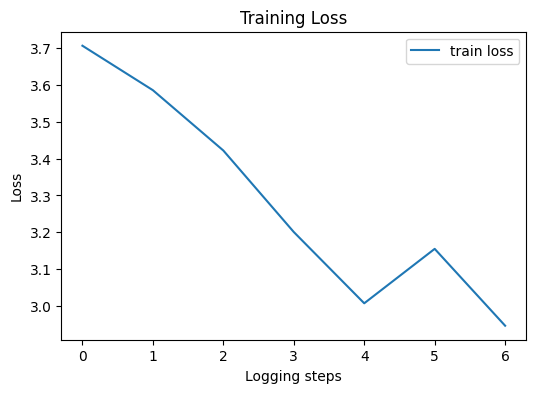


Training complete!

Saving model...

Model saved

Archiving model...

Model archived!


In [10]:
import shutil

model = create_model(target_dimension=target_dimension)
final_model_name = f"modernbert-embed-large-{split}-fine-tuned-limit-small-dim{target_dimension}"

print(f"\nStarting to train model {final_model_name}...")
train(
    model=model,
    batch_size=batch_size,
    mini_batch_size=mini_batch_size,
    num_epochs=num_epochs,
    train_dataset=train_dataset
)
print("\nTraining complete!")

print("\nSaving model...")
model.save(final_model_name, safe_serialization=True)
print("\nModel saved")

print("\nArchiving model...")
shutil.make_archive(final_model_name, "zip", final_model_name)
print("\nModel archived!")

Save model files using Kaggle API

In [11]:
import os
from kaggle_secrets import UserSecretsClient


user_secrets = UserSecretsClient()
os.environ["KAGGLE_USERNAME"] = user_secrets.get_secret("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = user_secrets.get_secret("KAGGLE_KEY")

username = os.environ["KAGGLE_USERNAME"]
assert username is not None, "KAGGLE_USERNAME is missing"



import kagglehub


final_model_name = f"modernbert-embed-large-{split}-fine-tuned-limit-small-dim{target_dimension}"
license = "Apache 2.0"

model_path = (
    f"{username}/modernbert-embed-large-finetuned/"
    f"transformers/{target_dimension}d-limit-small-{split}-cached-loss"
)

print("Uploading to:", model_path)

kagglehub.model_upload(
    model_path,
    final_model_name,
    license
)


Uploading to: gaborhosu121/modernbert-embed-large-finetuned/transformers/384d-limit-small-train-cached-loss
Uploading Model https://api.kaggle.com/models/gaborhosu121/modernbert-embed-large-finetuned/transformers/384d-limit-small-train-cached-loss ...


Uploading: 100%|██████████| 461/461 [00:00<00:00, 1.13kB/s]

Upload successful: modernbert-embed-large-train-fine-tuned-limit-small-dim384/modules.json (461B)
Starting upload for file modernbert-embed-large-train-fine-tuned-limit-small-dim384/sentence_bert_config.json



Uploading: 100%|██████████| 58.0/58.0 [00:00<00:00, 150B/s]

Upload successful: modernbert-embed-large-train-fine-tuned-limit-small-dim384/sentence_bert_config.json (58B)
Starting upload for file modernbert-embed-large-train-fine-tuned-limit-small-dim384/tokenizer.json



Uploading: 100%|██████████| 3.58M/3.58M [00:00<00:00, 7.88MB/s]

Upload successful: modernbert-embed-large-train-fine-tuned-limit-small-dim384/tokenizer.json (3MB)
Starting upload for file modernbert-embed-large-train-fine-tuned-limit-small-dim384/model.safetensors



Uploading: 100%|██████████| 1.58G/1.58G [00:13<00:00, 116MB/s] 

Upload successful: modernbert-embed-large-train-fine-tuned-limit-small-dim384/model.safetensors (1GB)
Starting upload for file modernbert-embed-large-train-fine-tuned-limit-small-dim384/special_tokens_map.json



Uploading: 100%|██████████| 694/694 [00:00<00:00, 1.74kB/s]

Upload successful: modernbert-embed-large-train-fine-tuned-limit-small-dim384/special_tokens_map.json (694B)
Starting upload for file modernbert-embed-large-train-fine-tuned-limit-small-dim384/config_sentence_transformers.json



Uploading: 100%|██████████| 283/283 [00:00<00:00, 704B/s]

Upload successful: modernbert-embed-large-train-fine-tuned-limit-small-dim384/config_sentence_transformers.json (283B)
Starting upload for file modernbert-embed-large-train-fine-tuned-limit-small-dim384/config.json



Uploading: 100%|██████████| 1.21k/1.21k [00:00<00:00, 3.12kB/s]

Upload successful: modernbert-embed-large-train-fine-tuned-limit-small-dim384/config.json (1KB)
Starting upload for file modernbert-embed-large-train-fine-tuned-limit-small-dim384/tokenizer_config.json



Uploading: 100%|██████████| 20.8k/20.8k [00:00<00:00, 53.1kB/s]

Upload successful: modernbert-embed-large-train-fine-tuned-limit-small-dim384/tokenizer_config.json (20KB)
Starting upload for file modernbert-embed-large-train-fine-tuned-limit-small-dim384/README.md



Uploading: 100%|██████████| 37.1k/37.1k [00:00<00:00, 95.6kB/s]

Upload successful: modernbert-embed-large-train-fine-tuned-limit-small-dim384/README.md (36KB)
Starting upload for file modernbert-embed-large-train-fine-tuned-limit-small-dim384/2_Dense/model.safetensors



Uploading: 100%|██████████| 1.57M/1.57M [00:00<00:00, 3.79MB/s]

Upload successful: modernbert-embed-large-train-fine-tuned-limit-small-dim384/2_Dense/model.safetensors (2MB)
Starting upload for file modernbert-embed-large-train-fine-tuned-limit-small-dim384/2_Dense/config.json



Uploading: 100%|██████████| 134/134 [00:00<00:00, 329B/s]

Upload successful: modernbert-embed-large-train-fine-tuned-limit-small-dim384/2_Dense/config.json (134B)
Starting upload for file modernbert-embed-large-train-fine-tuned-limit-small-dim384/1_Pooling/config.json



Uploading: 100%|██████████| 313/313 [00:00<00:00, 743B/s]

Upload successful: modernbert-embed-large-train-fine-tuned-limit-small-dim384/1_Pooling/config.json (313B)


Your model instance has been created.
Files are being processed...
See at: https://api.kaggle.com/models/gaborhosu121/modernbert-embed-large-finetuned/transformers/384d-limit-small-train-cached-loss


### Embed test dataset with finetuned models

Load test set

In [1]:
from datasets import load_dataset

# only embed the test set = the LIMIT-small dataset
dataset_name = "orionweller/LIMIT-small"

qrels = load_dataset(dataset_name, "default", split="test").to_pandas()
corpus = load_dataset(dataset_name, "corpus", split="all").to_pandas()
queries = load_dataset(dataset_name, "queries", split="all").to_pandas()

README.md: 0.00B [00:00, ?B/s]

qrels.jsonl: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

corpus.jsonl: 0.00B [00:00, ?B/s]

Generating corpus split:   0%|          | 0/46 [00:00<?, ? examples/s]

queries.jsonl: 0.00B [00:00, ?B/s]

Generating queries split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Load a model

In [2]:
# For compatibility we run the model instances on a single T4 GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda"

In [28]:
dimensions = [32, 64, 128, 256, 384, 512, 768, 1024]
splits = ["test", "train", "base"]

dimension = dimensions[7]
split=splits[2]
version = 1
base_directory = "/kaggle/input/modernbert-embed-large-finetuned/transformers"
model_variation = f"{dimension}d-limit-small-{split}-cached-loss/{version}"

model_variation

'1024d-limit-small-base-cached-loss/1'

In [29]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(
    f"{base_directory}/{model_variation}",
    local_files_only=True,
    device=device
)

Embed the test set

In [5]:
import pickle
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

def embed_dataset(
    corpus: pd.DataFrame,
    queries: pd.DataFrame,
    model: SentenceTransformer,
    save_path: str,
    batch_size: int = 512
):
    sentences = [text for text in corpus["text"]]
    embeddings = model.encode(sentences, batch_size=batch_size, show_progress_bar=True)
    doc_embs = {_id: emb for _id, emb in zip(corpus["_id"], embeddings)}
    
    sentences = [text for text in queries["text"]]
    embeddings = model.encode(sentences, batch_size=batch_size, show_progress_bar=True)
    query_embs = {_id: emb for _id, emb in zip(queries["_id"], embeddings)}
    
    with open(save_path, "wb") as file:
        pickle.dump([doc_embs, query_embs], file)

In [30]:
variation = model_variation.split("/")[0]
embed_dataset(
    corpus=corpus,
    queries=queries,
    model=model,
    save_path=f"modernbert-large-finetuned-{variation}.pkl"
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

## Evaluate results on the generated embeddings

Load test set

In [1]:
from datasets import load_dataset

dataset_name = "orionweller/LIMIT-small"

qrels = load_dataset(dataset_name, "default", split="test").to_pandas()
corpus = load_dataset(dataset_name, "corpus", split="all").to_pandas()
queries = load_dataset(dataset_name, "queries", split="all").to_pandas()

README.md: 0.00B [00:00, ?B/s]

qrels.jsonl: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

corpus.jsonl: 0.00B [00:00, ?B/s]

Generating corpus split:   0%|          | 0/46 [00:00<?, ? examples/s]

queries.jsonl: 0.00B [00:00, ?B/s]

Generating queries split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Load embeddings

In [2]:
import numpy as np
import pickle

def load_embeded_dataset(
    embbedings_path: str
) -> tuple[dict[str, np.ndarray], dict[str, np.ndarray]]:
    with open(embbedings_path, "rb") as file:
        doc_embs, query_embs = pickle.load(file)

    return doc_embs, query_embs

Calculate recalls

In [3]:
import pandas as pd

def recall(
    recall_at: int, 
    corpus: pd.DataFrame,
    queries: pd.DataFrame,
    qrels: pd.DataFrame,
    query_embs: dict[str, np.ndarray],
    doc_embs: dict[str, np.ndarray],
) -> float:        
        # align embedding matrices with corpus/query order (for safety)
        D = np.stack([doc_embs[_id] for _id in corpus["_id"]])
        Q = np.stack([query_embs[qid] for qid in queries["_id"]])        
        D = D.astype(np.float64, copy=False)
        Q = Q.astype(np.float64, copy=False)

        A = Q @ D.T
        
        # uses quickselect under the hood
        # we need to select indexes of the top-k largest values -> -A
        retrieved_docs = np.argpartition(-A, kth=recall_at-1, axis=1)[:, :recall_at]
        retrieved_docs = [
            set(corpus["_id"].iloc[docs].to_list())
            for docs in retrieved_docs
        ]
    
        qrels_map = (
            qrels.groupby("query-id")["corpus-id"]
            .apply(set)
            .to_dict()
        )
        
        relevant_docs = [
            qrels_map[qid]
            for qid in queries["_id"]
        ]
    
        total = 0
        for ret, rel in zip(retrieved_docs, relevant_docs):
            total += len(ret & rel) / len(rel)
            
        return total / len(relevant_docs)

In [4]:
dims = [32, 64, 128, 256, 384, 512, 768, 1024]
def get_embeddings_path(dim: int, split: str) -> str:
    return f"/kaggle/working/modernbert-large-finetuned-{dim}d-limit-small-{split}-cached-loss.pkl"    

In [5]:
test_recalls = []
train_recalls = []
for d in dims:
    for split in ["test", "train"]:
        doc_embs, query_embs = load_embeded_dataset(
            embbedings_path=get_embeddings_path(dim=d, split=split)
        )
        print(f"dim: {d}, split: {split}")        
        r = 10
        rec = recall(
            recall_at=r, 
            corpus=corpus,
            queries=queries,
            qrels=qrels,
            doc_embs=doc_embs,
            query_embs=query_embs
        )
        print(f"recall@{r} = {rec}")
        if split == "test":
            test_recalls.append(rec)
        else:
            train_recalls.append(rec)
            

dim: 32, split: test
recall@10 = 0.3975
dim: 32, split: train
recall@10 = 0.384
dim: 64, split: test
recall@10 = 0.462
dim: 64, split: train
recall@10 = 0.4685
dim: 128, split: test
recall@10 = 0.5665
dim: 128, split: train
recall@10 = 0.5625
dim: 256, split: test
recall@10 = 0.6345
dim: 256, split: train
recall@10 = 0.658
dim: 384, split: test
recall@10 = 0.7015
dim: 384, split: train
recall@10 = 0.692
dim: 512, split: test
recall@10 = 0.745
dim: 512, split: train
recall@10 = 0.693
dim: 768, split: test
recall@10 = 0.7585
dim: 768, split: train
recall@10 = 0.7425
dim: 1024, split: test
recall@10 = 0.809
dim: 1024, split: train
recall@10 = 0.7745


Generate plot with the most good looking recalls

In [ ]:
def visualize(
    recalls_of: dict[str, dict[str, list[float]]],
    extra_model_name_suffix: str = "",
    save_diagram: bool = False,
    saved_diagram_name: str = None
):
    dims_to_plot = [32, 512, 1024, 2048, 3072, 4096]
    recalls_to_plot = [0, 0.2, 0.4, 0.6, 0.8, 1]
    dims = [32, 64, 128, 256, 512, 768, 1024, 2048, 3072, 4096]
    
    mrl_model_names = {"SnowflakeArcticL", "Qwen3Embed8B", "Qwen3Embed06B"}
    extra_models = ["BM25", "GTEModernColBERT"]
    extra_model_colors = ["gray", "brown"]
    model_names = set(recalls_of[list(recalls_of.keys())[0]]) - set(extra_models)
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 6))
    
    for i, dataset_type in enumerate(recalls):
        axis = axes[i]
        axis.set_title(dataset_type)
        axis.set_xlabel("Dimension")
        if i == 0:
            axis.set_ylabel("Recall@100")
        axis.set_ylim(0, 1.05)
        axis.set_xticks(dims_to_plot)
        axis.set_xticklabels([str(d) for d in dims_to_plot])
        axis.set_yticks(recalls_to_plot)
        axis.set_yticklabels([str(r) for r in recalls_to_plot])

        dataset_recalls = recalls_of[dataset_type]
        for model_name in model_names:
            model_recalls = dataset_recalls[model_name]
            axes[i].plot(
                dims, 
                model_recalls, 
                marker='*' if model_name in mrl_model_names else ".", 
                label=model_name
            )

    
        for model_name, color in zip(extra_models, extra_model_colors):
            model_recalls = dataset_recalls[model_name]
            axes[i].axhline(
                y=model_recalls[0],
                linestyle="--",
                linewidth=1.40,
                color=color,
                label=f"{model_name}{extra_model_name_suffix}"
            )
    
    # set legend by removing duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(
        by_label.values(), 
        by_label.keys(), 
        loc='lower center', 
        ncol=4, 
        bbox_to_anchor=(0.5, -0.1)
    )
        
    plt.tight_layout()
    plt.show()
    if save_diagram:
        saved_diagram_name = saved_diagram_name or "recalls_diagram.pdf"
        fig.savefig(saved_diagram_name, bbox_inches='tight')

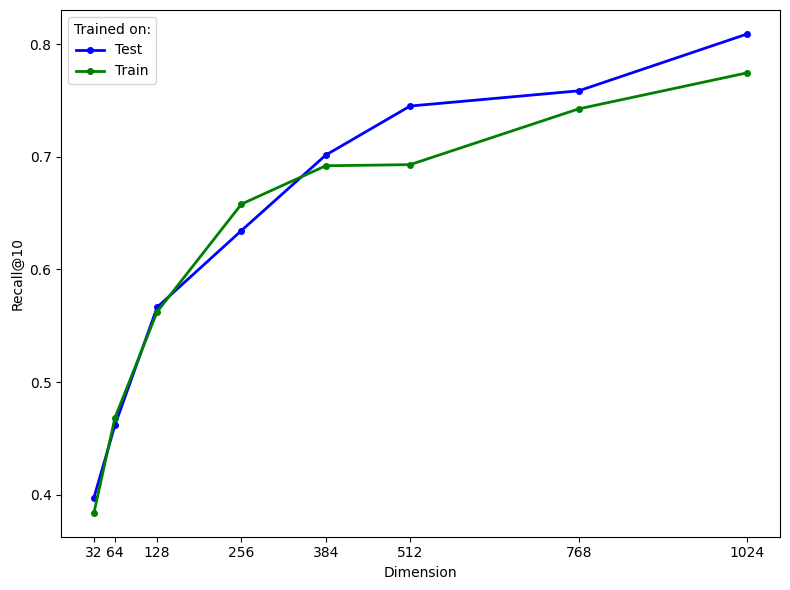

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.xticks(dims)

plt.plot(dims, test_recalls, marker='.', linewidth=2, markersize=8, color="blue", label="Test")
plt.plot(dims, train_recalls, marker='.', linewidth=2, markersize=8, color="green", label="Train")

plt.xlabel("Dimension")
plt.ylabel("Recall@10")

plt.legend(title="Trained on:")

plt.tight_layout()

plt.savefig("domain_shift.pdf", bbox_inches="tight")

plt.show()